In [1]:
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 


import matplotlib.cm as cm
import matplotlib.colors as colors


from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0

The following packages will be UPDATED:

  openssl                                 1.1.1f-h516909a_0 --> 1.1.1g-h516909a_0



openssl-1.1.1g       | 2.1 MB    | ############

In [2]:
with open('us-zip-code-latitude-and-longitude.json') as json_data:
    MA_data = json.load(json_data)

In [3]:
MA_data[3]

{'datasetid': 'us-zip-code-latitude-and-longitude',
 'recordid': '5bddac038c2fc2871873d20e4abf3788d2eb0a72',
 'fields': {'city': 'Dennis Port',
  'zip': '02639',
  'dst': 1,
  'geopoint': [41.661115, -70.13348],
  'longitude': -70.13348,
  'state': 'MA',
  'latitude': 41.661115,
  'timezone': -5},
 'geometry': {'type': 'Point', 'coordinates': [-70.13348, 41.661115]},
 'record_timestamp': '2018-02-10T00:33:38.603+08:00'}

In [4]:
column_names = ['ZipCode','Latitude','Longitude','Neighborhood'] 
MA_neighborhoods = pd.DataFrame(columns=column_names)
MA_neighborhoods

,ZipCode,Latitude,Longitude,Neighborhood


In [5]:
for data in MA_data:
    neighborhood = data['fields']['city'] 
    zip_code = data['fields']['zip']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    MA_neighborhoods = MA_neighborhoods.append({'ZipCode':zip_code,
                                          'Latitude':neighborhood_lat,
                                          'Longitude':neighborhood_lon,
                                            'Neighborhood':neighborhood}, ignore_index=True)


In [6]:
MA_neighborhoods.head()


,ZipCode,Latitude,Longitude,Neighborhood
0,02472,42.371296,-71.18196,Watertown
1,02169,42.250739,-70.99593,Quincy
2,02375,42.029749,-71.10191,South Easton
3,02639,41.661115,-70.13348,Dennis Port
4,02382,42.082350,-70.93734,Whitman


In [7]:
BOS_neigh = pd.read_csv('postal code bos.csv', header=None)
BOS_neigh[0] = '0' + BOS_neigh[0].astype(str)
BOS_neigh.columns=['ZipCode','Neighborhood']
BOS_neigh.head()

,ZipCode,Neighborhood
0,02101,Downtown Boston
1,02108,Beacon Hill
2,02109,Markets / Inner Harbor
3,02110,Financial District / Wharves
4,02111,Chinatown / Tufts-New England Medical Center


In [8]:
merged_left = pd.merge(left=BOS_neigh, right=MA_neighborhoods, how='left', left_on='ZipCode',right_on='ZipCode')
bos_data=merged_left.dropna()
bos_data=bos_data.reset_index()
bos_data=bos_data.iloc[:,1:6]
#After visualizing the data, I found 3 of the locations were off, so I changed the coordinates manually.
bos_data=bos_data.replace(to_replace=42.446396,value=42.37000000)
bos_data=bos_data.replace(to_replace=-71.459405,value=-71.10000000)
bos_data=bos_data.replace(to_replace=42.338947,value=42.35787)
bos_data=bos_data.replace(to_replace=-70.919635,value=-71.05731)
bos_data=bos_data.replace(to_replace=42.180048,value=42.3336)
bos_data=bos_data.replace(to_replace=-71.089230,value=-71.1237)
bos_data=bos_data.iloc[:,0:4]
bos_data.head()

,ZipCode,Neighborhood_x,Latitude,Longitude
0,02101,Downtown Boston,42.370567,-71.026964
1,02108,Beacon Hill,42.357903,-71.064080
2,02109,Markets / Inner Harbor,42.361477,-71.054170
3,02110,Financial District / Wharves,42.356532,-71.053650
4,02111,Chinatown / Tufts-New England Medical Center,42.349838,-71.061010


In [9]:
address = 'Boston, MA'

geolocator = Nominatim(user_agent="boston_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Boston are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Boston are 42.3602534, -71.0582912.


In [10]:
# create map of BOS using latitude and longitude values
map_bos = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for zcode, lat, lng, neighborhood in zip(bos_data['ZipCode'],bos_data['Latitude'], bos_data['Longitude'], bos_data['Neighborhood_x']):
    label = '{},{}'.format(neighborhood,zcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bos)  
    
map_bos

In [11]:
CLIENT_ID = 'ASU55OYPCPYOGFBX5OPURXU4BDQFRYSAFRLII4JVOWALB5ZS' # your Foursquare ID
CLIENT_SECRET = 'QBFB3353CLIIKHCGMS3EJ3OSXHYHWQUXVJ3RU5XJFJ1YMZ2D' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
LIMIT=100
bos_venues = getNearbyVenues(names=bos_data['Neighborhood_x'],
                                   latitudes=bos_data['Latitude'],
                                   longitudes=bos_data['Longitude'])

Downtown Boston
Beacon Hill
Markets / Inner Harbor
Financial District / Wharves
Chinatown / Tufts-New England Medical Center
Downtown Boston
North End
West End / Back of the Hill
Fenway / East Fens / Longwood
Back Bay
Downtown Boston
South End
Roxbury
Roxbury Crossing
Roxbury / Grove Hall
Dorchester / Fields Corner
Downtown Boston
Dorchester / Codman Square
Dorchester / Uphams Corner
Mattapan
South Boston
East Boston
Charlestown
Jamaica Plain
Roslindale
West Roxbury
Downtown Boston
Allston
Brighton
Hyde Park
Readville
Cambridge
Cambridge
Cambridge
Cambridge
Cambridge
Somerville
Somerville
Somerville
North Brighton / Cambridge
Downtown Boston
Prudential
Downtown Boston
Downtown Boston
South Boston / Fort Point
Kenmore / Boston University
Downtown Boston
Cambridge
Brookline
Brookline
Brookline Village


In [14]:
print(bos_venues.shape)
bos_venues.head()

(2467, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Boston,42.370567,-71.026964,Alamo Rent A Car,42.368561,-71.029946,Rental Car Location
1,Downtown Boston,42.370567,-71.026964,Memorial Park,42.372588,-71.031452,Park
2,Downtown Boston,42.370567,-71.026964,National Car Rental,42.368013,-71.030275,Rental Car Location
3,Downtown Boston,42.370567,-71.026964,Unified Rental Car Center,42.368181,-71.029444,Rental Car Location
4,Downtown Boston,42.370567,-71.026964,Au Bon Pain,42.370202,-71.025607,Café


In [15]:
bos_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allston,78,78,78,78,78,78
Back Bay,100,100,100,100,100,100
Beacon Hill,82,82,82,82,82,82
Brighton,42,42,42,42,42,42
Brookline,83,83,83,83,83,83
Brookline Village,53,53,53,53,53,53
Cambridge,210,210,210,210,210,210
Charlestown,26,26,26,26,26,26
Chinatown / Tufts-New England Medical Center,100,100,100,100,100,100


In [16]:
print('There are {} uniques categories.'.format(len(bos_venues['Venue Category'].unique())))

There are 261 uniques categories.


In [17]:
# one hot encoding
bos_onehot = pd.get_dummies(bos_venues[['Venue Category']], prefix="", prefix_sep="")
bos_onehot = bos_onehot.drop(['Neighborhood'],axis=1)


In [18]:
bos_onehot['Neighborhood'] = bos_venues['Neighborhood'] 
# move neighborhood column to the first column

fixed_columns = [bos_onehot.columns[-1]] + list(bos_onehot.columns[:-1])
bos_onehot = bos_onehot[fixed_columns]

bos_onehot.head()


,Neighborhood,Accessories Store,African Restaurant,Airport,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Chalet,Smoke Shop,Smoothie Shop,Soba Restaurant,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Taxi Stand,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Trail,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Downtown Boston,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [19]:
bos_grouped = bos_onehot.groupby('Neighborhood').mean().reset_index()
bos_grouped.head()

,Neighborhood,Accessories Store,African Restaurant,Airport,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Chalet,Smoke Shop,Smoothie Shop,Soba Restaurant,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Taxi Stand,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Trail,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Allston,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.038462,0.000000,0.0,0.012821,0.0,0.0,0.000000,0.038462,0.000000,0.012821,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.012821,0.0,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,0.012821

In [20]:
bos_grouped.shape

(35, 261)

In [21]:
num_top_venues = 5

for hood in bos_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = bos_grouped[bos_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allston----
               venue  freq
0  Korean Restaurant  0.08
1   Asian Restaurant  0.04
2    Thai Restaurant  0.04
3        Pizza Place  0.04
4             Bakery  0.04


----Back Bay----
                  venue  freq
0                   Spa  0.07
1  Gym / Fitness Center  0.05
2                   Gym  0.04
3    Seafood Restaurant  0.04
4    Italian Restaurant  0.04


----Beacon Hill----
                 venue  freq
0          Pizza Place  0.05
1  American Restaurant  0.05
2         Cocktail Bar  0.04
3          Coffee Shop  0.04
4        Historic Site  0.04


----Brighton----
         venue  freq
0  Bus Station  0.07
1         Bank  0.07
2  Pizza Place  0.07
3       Bakery  0.07
4          Pub  0.05


----Brookline----
                  venue  freq
0                  Café  0.05
1           Pizza Place  0.05
2  Gym / Fitness Center  0.04
3             Gift Shop  0.04
4      Sushi Restaurant  0.04


----Brookline Village----
                venue  freq
0         Pizza Place  0.0

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bos_grouped['Neighborhood']

for ind in np.arange(bos_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bos_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allston,Korean Restaurant,Asian Restaurant,Pizza Place,Sushi Restaurant,Bakery,Thai Restaurant,Chinese Restaurant,Liquor Store,Pharmacy,Thrift / Vintage Store
1,Back Bay,Spa,Gym / Fitness Center,Gym,Seafood Restaurant,Italian Restaurant,Sandwich Place,Women's Store,American Restaurant,Clothing Store,Gourmet Shop
2,Beacon Hill,American Restaurant,Pizza Place,New American Restaurant,Sandwich Place,Restaurant,Italian Restaurant,Hotel,Cocktail Bar,Coffee Shop,Historic Site
3,Brighton,Bus Station,Pizza Place,Bank,Bakery,Café,Chinese Restaurant,Pub,Mobile Phone Shop,Smoke Shop,Metro Station
4,Brookline,Café,Pizza Place,Gift Shop,Sushi Restaurant,Gym / Fitness Center,Japanese Restaurant,Nail Salon,Sandwich Place,Gym,Bagel Shop


In [58]:
from sklearn.metrics import silhouette_score

bos_grouped_clustering = bos_grouped.drop('Neighborhood', 1)

sil = []
kmax = 15

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(bos_grouped_clustering)
  labels = kmeans.labels_
  sil.append(silhouette_score(bos_grouped_clustering, labels, metric = 'euclidean'))

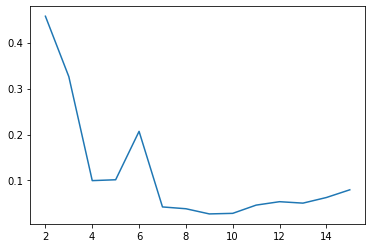

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
x=range(2,kmax+1)
y=sil
plt.plot(x, y)

In [44]:
# set number of clusters
kclusters = 6

bos_grouped_clustering = bos_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bos_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 4, 1, 4, 4, 4, 1, 4, 1], dtype=int32)

In [27]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bos_merged = bos_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bos_merged = bos_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood_x')

bos_merged.head() 

,ZipCode,Neighborhood_x,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,02101,Downtown Boston,42.370567,-71.026964,4,Coffee Shop,Historic Site,American Restaurant,Hotel,Sandwich Place,Steakhouse,Pub,Italian Restaurant,Bakery,Restaurant
1,02108,Beacon Hill,42.357903,-71.064080,4,American Restaurant,Pizza Place,New American Restaurant,Sandwich Place,Restaurant,Italian Restaurant,Hotel,Cocktail Bar,Coffee Shop,Historic Site
2,02109,Markets / Inner Harbor,42.361477,-71.054170,2,Italian Restaurant,Bakery,Seafood Restaurant,Park,Historic Site,Sandwich Place,Pizza Place,Wine Shop,American Restaurant,Hotel
3,02110,Financial District / Wharves,42.356532,-71.053650,4,Historic Site,Boat or Ferry,Park,Italian Restaurant,Harbor / Marina,Aquarium,Coffee Shop,Tea Room,Hotel,Bakery
4,02111,Chinatown / Tufts-New England Medical Center,42.349838,-71.061010,4,Chinese Restaurant,Bakery,Asian Restaurant,Sushi Restaurant,Theater,Bubble Tea Shop,Performing Arts Venue,Coffee Shop,Hotel Bar,Café


In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bos_merged['Latitude'], bos_merged['Longitude'], bos_merged['Neighborhood_x'], bos_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [29]:
bos_merged.loc[bos_merged['Cluster Labels'] == 0, bos_merged.columns[[1] + list(range(5, bos_merged.shape[1]))]]

,Neighborhood_x,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,East Boston,Italian Restaurant,Construction & Landscaping,Chinese Restaurant,Trail,Metro Station,Mexican Restaurant,Liquor Store,Peruvian Restaurant,Latin American Restaurant,Dessert Shop


In [30]:
bos_merged.loc[bos_merged['Cluster Labels'] == 1, bos_merged.columns[[1] + list(range(5, bos_merged.shape[1]))]]

,Neighborhood_x,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Roxbury Crossing,Pizza Place,Donut Shop,Convenience Store,Gym,Metro Station,Furniture / Home Store,Bike Rental / Bike Share,Liquor Store,Light Rail Station,Track
15,Dorchester / Fields Corner,Seafood Restaurant,Pizza Place,Donut Shop,Liquor Store,Sandwich Place,Pet Store,Pharmacy,Bank,Vietnamese Restaurant,Cosmetics Shop
17,Dorchester / Codman Square,Deli / Bodega,Liquor Store,Restaurant,Diner,Pharmacy,Farmers Market,Caribbean Restaurant,Park,Fast Food Restaurant,Grocery Store
18,Dorchester / Uphams Corner,Pub,Pizza Place,Liquor Store,Convenience Store,Pharmacy,Caribbean Restaurant,Fried Chicken Joint,Deli / Bodega,Grocery Store,Bar
19,Mattapan,Pizza Place,Home Service,Nail Salon,Fast Food Restaurant,Bank,Bakery,Caribbean Restaurant,Pharmacy,Hot Dog Joint,Donut Shop
22,Charlestown,Pizza Place,Coffee Shop,Convenience Store,Yoga Studio,Donut Shop,Monument / Landmark,Pool,Café,Shopping Mall,Gastropub
24,Roslindale,Italian Restaurant,American Restaurant,Bakery,Pizza Place,Bank,Restaurant,Cheese Shop,Bar,Farmers Market,Park
25,West Roxbury,Grocery Store,Pub,Pharmacy,Bank,Clothing Store,Locksmith,Liquor Store,Automotive Shop,Salon / Barbershop,Donut Shop
28,Brighton,Bus Station,Pizza Place,Bank,Bakery,Café,Chinese Restaurant,Pub,Mobile Phone Shop,Smoke Shop,Metro Station
29,Hyde Park,American Restaurant,Clothing Store,Pharmacy,Sandwich Place,Chinese Restaurant,Bank,Skate Park,Grocery Store,Fast Food Restaurant,Park


In [31]:
bos_merged.loc[bos_merged['Cluster Labels'] == 2, bos_merged.columns[[1] + list(range(5, bos_merged.shape[1]))]]

,Neighborhood_x,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Markets / Inner Harbor,Italian Restaurant,Bakery,Seafood Restaurant,Park,Historic Site,Sandwich Place,Pizza Place,Wine Shop,American Restaurant,Hotel
6,North End,Italian Restaurant,Seafood Restaurant,Pizza Place,Coffee Shop,Hotel,Hockey Arena,Bakery,Sandwich Place,Café,Boutique


In [32]:
bos_merged.loc[bos_merged['Cluster Labels'] == 3, bos_merged.columns[[1] + list(range(5, bos_merged.shape[1]))]]

,Neighborhood_x,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Roxbury,Park,American Restaurant,Bike Rental / Bike Share,African Restaurant,Convenience Store,Food Service,Field,Fish Market,Flea Market,Food & Drink Shop


In [33]:
bos_merged.loc[bos_merged['Cluster Labels'] == 4, bos_merged.columns[[1] + list(range(5, bos_merged.shape[1]))]]

,Neighborhood_x,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Boston,Coffee Shop,Historic Site,American Restaurant,Hotel,Sandwich Place,Steakhouse,Pub,Italian Restaurant,Bakery,Restaurant
1,Beacon Hill,American Restaurant,Pizza Place,New American Restaurant,Sandwich Place,Restaurant,Italian Restaurant,Hotel,Cocktail Bar,Coffee Shop,Historic Site
3,Financial District / Wharves,Historic Site,Boat or Ferry,Park,Italian Restaurant,Harbor / Marina,Aquarium,Coffee Shop,Tea Room,Hotel,Bakery
4,Chinatown / Tufts-New England Medical Center,Chinese Restaurant,Bakery,Asian Restaurant,Sushi Restaurant,Theater,Bubble Tea Shop,Performing Arts Venue,Coffee Shop,Hotel Bar,Café
5,Downtown Boston,Coffee Shop,Historic Site,American Restaurant,Hotel,Sandwich Place,Steakhouse,Pub,Italian Restaurant,Bakery,Restaurant
7,West End / Back of the Hill,Italian Restaurant,Pizza Place,American Restaurant,History Museum,Food Truck,Yoga Studio,Burrito Place,Grocery Store,Mediterranean Restaurant,Gourmet Shop
8,Fenway / East Fens / Longwood,Pizza Place,Art Museum,Restaurant,Garden,Coffee Shop,Thai Restaurant,Middle Eastern Restaurant,Burger Joint,Café,Grocery Store
9,Back Bay,Spa,Gym / Fitness Center,Gym,Seafood Restaurant,Italian Restaurant,Sandwich Place,Women's Store,American Restaurant,Clothing Store,Gourmet Shop
10,Downtown Boston,Coffee Shop,Historic Site,American Restaurant,Hotel,Sandwich Place,Steakhouse,Pub,Italian Restaurant,Bakery,Restaurant
11,South End,Park,Sandwich Place,Pizza Place,Mediterranean Restaurant,Diner,Coffee Shop,Donut Shop,Café,Gift Shop,Bus Stop


In [34]:
bos_merged.loc[bos_merged['Cluster Labels'] == 5, bos_merged.columns[[1] + list(range(5, bos_merged.shape[1]))]]

,Neighborhood_x,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Roxbury / Grove Hall,Fast Food Restaurant,Shopping Mall,Caribbean Restaurant,Donut Shop,Farmers Market,Cosmetics Shop,Nightclub,Supermarket,Pharmacy,Field


In [35]:
first = bos_merged.loc[bos_merged['1st Most Common Venue'].isin(['Asian Restaurant','Chinese Restaurant','Korean Restaurant','Japanese Restaurant','Dim Sum Restaurant','Dumpling Restaurant','Hotpot Restaurant','Shanghai Restaurant','Ramen Restaurant','Udon Restaurant','Thai Restaurant','Malay Restaurant'])]
first

,ZipCode,Neighborhood_x,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,02111,Chinatown / Tufts-New England Medical Center,42.349838,-71.06101,4,Chinese Restaurant,Bakery,Asian Restaurant,Sushi Restaurant,Theater,Bubble Tea Shop,Performing Arts Venue,Coffee Shop,Hotel Bar,Café
27,02134,Allston,42.355147,-71.13164,4,Korean Restaurant,Asian Restaurant,Pizza Place,Sushi Restaurant,Bakery,Thai Restaurant,Chinese Restaurant,Liquor Store,Pharmacy,Thrift / Vintage Store


In [36]:
second = bos_merged.loc[bos_merged['2nd Most Common Venue'].isin(['Asian Restaurant','Chinese Restaurant','Korean Restaurant','Japanese Restaurant','Dim Sum Restaurant','Dumpling Restaurant','Hotpot Restaurant','Shanghai Restaurant','Ramen Restaurant','Udon Restaurant','Thai Restaurant','Malay Restaurant'])]
second

,ZipCode,Neighborhood_x,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,02134,Allston,42.355147,-71.13164,4,Korean Restaurant,Asian Restaurant,Pizza Place,Sushi Restaurant,Bakery,Thai Restaurant,Chinese Restaurant,Liquor Store,Pharmacy,Thrift / Vintage Store


In [37]:
third = bos_merged.loc[bos_merged['3rd Most Common Venue'].isin(['Asian Restaurant','Chinese Restaurant','Korean Restaurant','Japanese Restaurant','Dim Sum Restaurant','Dumpling Restaurant','Hotpot Restaurant','Shanghai Restaurant','Ramen Restaurant','Udon Restaurant','Thai Restaurant','Malay Restaurant'])]
third

,ZipCode,Neighborhood_x,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,02111,Chinatown / Tufts-New England Medical Center,42.349838,-71.06101,4,Chinese Restaurant,Bakery,Asian Restaurant,Sushi Restaurant,Theater,Bubble Tea Shop,Performing Arts Venue,Coffee Shop,Hotel Bar,Café
21,02128,East Boston,42.378297,-71.02550,0,Italian Restaurant,Construction & Landscaping,Chinese Restaurant,Trail,Metro Station,Mexican Restaurant,Liquor Store,Peruvian Restaurant,Latin American Restaurant,Dessert Shop
39,02163,North Brighton / Cambridge,42.367946,-71.12056,4,Park,Pizza Place,Japanese Restaurant,Bookstore,Plaza,Clothing Store,Music Venue,Bar,Gym / Fitness Center,Gym


In [38]:
fourth = bos_merged.loc[bos_merged['4th Most Common Venue'].isin(['Asian Restaurant','Chinese Restaurant','Korean Restaurant','Japanese Restaurant','Dim Sum Restaurant','Dumpling Restaurant','Hotpot Restaurant','Shanghai Restaurant','Ramen Restaurant','Udon Restaurant','Thai Restaurant','Malay Restaurant'])]
fourth

,ZipCode,Neighborhood_x,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [39]:
fifth = bos_merged.loc[bos_merged['5th Most Common Venue'].isin(['Asian Restaurant','Chinese Restaurant','Korean Restaurant','Japanese Restaurant','Dim Sum Restaurant','Dumpling Restaurant','Hotpot Restaurant','Shanghai Restaurant','Ramen Restaurant','Udon Restaurant','Thai Restaurant','Malay Restaurant'])]
fifth

,ZipCode,Neighborhood_x,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,02136,Hyde Park,42.252198,-71.12593,1,American Restaurant,Clothing Store,Pharmacy,Sandwich Place,Chinese Restaurant,Bank,Skate Park,Grocery Store,Fast Food Restaurant,Park
45,02215,Kenmore / Boston University,42.346997,-71.10215,4,Café,American Restaurant,Lounge,Mexican Restaurant,Japanese Restaurant,Bakery,Thai Restaurant,Coffee Shop,Donut Shop,Greek Restaurant
50,02447,Brookline Village,42.333600,-71.12370,4,Pizza Place,Italian Restaurant,Gym,Sporting Goods Shop,Chinese Restaurant,Coffee Shop,Sandwich Place,Playground,Park,Donut Shop


In [40]:
Asian = pd.concat([first, second, third, fourth, fifth], axis=0, sort=False)
Asian

,ZipCode,Neighborhood_x,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,02111,Chinatown / Tufts-New England Medical Center,42.349838,-71.06101,4,Chinese Restaurant,Bakery,Asian Restaurant,Sushi Restaurant,Theater,Bubble Tea Shop,Performing Arts Venue,Coffee Shop,Hotel Bar,Café
27,02134,Allston,42.355147,-71.13164,4,Korean Restaurant,Asian Restaurant,Pizza Place,Sushi Restaurant,Bakery,Thai Restaurant,Chinese Restaurant,Liquor Store,Pharmacy,Thrift / Vintage Store
27,02134,Allston,42.355147,-71.13164,4,Korean Restaurant,Asian Restaurant,Pizza Place,Sushi Restaurant,Bakery,Thai Restaurant,Chinese Restaurant,Liquor Store,Pharmacy,Thrift / Vintage Store
4,02111,Chinatown / Tufts-New England Medical Center,42.349838,-71.06101,4,Chinese Restaurant,Bakery,Asian Restaurant,Sushi Restaurant,Theater,Bubble Tea Shop,Performing Arts Venue,Coffee Shop,Hotel Bar,Café
21,02128,East Boston,42.378297,-71.02550,0,Italian Restaurant,Construction & Landscaping,Chinese Restaurant,Trail,Metro Station,Mexican Restaurant,Liquor Store,Peruvian Restaurant,Latin American Restaurant,Dessert Shop
39,02163,North Brighton / Cambridge,42.367946,-71.12056,4,Park,Pizza Place,Japanese Restaurant,Bookstore,Plaza,Clothing Store,Music Venue,Bar,Gym / Fitness Center,Gym
29,02136,Hyde Park,42.252198,-71.12593,1,American Restaurant,Clothing Store,Pharmacy,Sandwich Place,Chinese Restaurant,Bank,Skate Park,Grocery Store,Fast Food Restaurant,Park
45,02215,Kenmore / Boston University,42.346997,-71.10215,4,Café,American Restaurant,Lounge,Mexican Restaurant,Japanese Restaurant,Bakery,Thai Restaurant,Coffee Shop,Donut Shop,Greek Restaurant
50,02447,Brookline Village,42.333600,-71.12370,4,Pizza Place,Italian Restaurant,Gym,Sporting Goods Shop,Chinese Restaurant,Coffee Shop,Sandwich Place,Playground,Park,Donut Shop


In [41]:
Asian=Asian.drop_duplicates(subset=None, keep='first', inplace=False)
Asian=Asian.reset_index(drop=True)
Asian

,ZipCode,Neighborhood_x,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,02111,Chinatown / Tufts-New England Medical Center,42.349838,-71.06101,4,Chinese Restaurant,Bakery,Asian Restaurant,Sushi Restaurant,Theater,Bubble Tea Shop,Performing Arts Venue,Coffee Shop,Hotel Bar,Café
1,02134,Allston,42.355147,-71.13164,4,Korean Restaurant,Asian Restaurant,Pizza Place,Sushi Restaurant,Bakery,Thai Restaurant,Chinese Restaurant,Liquor Store,Pharmacy,Thrift / Vintage Store
2,02128,East Boston,42.378297,-71.02550,0,Italian Restaurant,Construction & Landscaping,Chinese Restaurant,Trail,Metro Station,Mexican Restaurant,Liquor Store,Peruvian Restaurant,Latin American Restaurant,Dessert Shop
3,02163,North Brighton / Cambridge,42.367946,-71.12056,4,Park,Pizza Place,Japanese Restaurant,Bookstore,Plaza,Clothing Store,Music Venue,Bar,Gym / Fitness Center,Gym
4,02136,Hyde Park,42.252198,-71.12593,1,American Restaurant,Clothing Store,Pharmacy,Sandwich Place,Chinese Restaurant,Bank,Skate Park,Grocery Store,Fast Food Restaurant,Park
5,02215,Kenmore / Boston University,42.346997,-71.10215,4,Café,American Restaurant,Lounge,Mexican Restaurant,Japanese Restaurant,Bakery,Thai Restaurant,Coffee Shop,Donut Shop,Greek Restaurant
6,02447,Brookline Village,42.333600,-71.12370,4,Pizza Place,Italian Restaurant,Gym,Sporting Goods Shop,Chinese Restaurant,Coffee Shop,Sandwich Place,Playground,Park,Donut Shop


In [42]:
# create map
map_Asian = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
markers_colors1 = []
for lat, lon, poi in zip(Asian['Latitude'], Asian['Longitude'], Asian['Neighborhood_x']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#ADD8E6',
        fill_opacity=0.7).add_to(map_Asian)
       
map_Asian